<a href="https://colab.research.google.com/github/abhi2596/Image-Colorization/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow
import glob
import os
from PIL import Image,ImageOps
import torch
from torchvision.models.vgg import VGG16_BN_Weights
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.optim
import cv2
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# change resize to 256 with center crop 224 
class Colorization_Dataset(Dataset):
  def __init__(self,file_location,indices):
    self.location = file_location
    # self.image_location = os.listdir(file_location)
    self.image_location = sorted(os.listdir(file_location)[indices[0]:indices[1]])
  def __len__(self):
    return len(self.image_location)
  def __getitem__(self,idx):
    image_bgr = cv2.imread(os.path.join(self.location, self.image_location[idx]))
    image_rgb = cv2.cvtColor(image_bgr,cv2.COLOR_BGR2RGB)
    image_rgb = Image.fromarray(image_rgb)
    image_rgb = transforms.functional.resize(image_rgb,(224,224))
    image_rgb = np.array(image_rgb)
    image_luv = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2Luv)
    image_luv = transforms.functional.to_tensor(image_luv)
    image_l = torch.stack((image_luv[0],image_luv[0],image_luv[0]),dim=0)
    image_l = transforms.functional.normalize(
        image_l,
        mean=[0.4697]*3, 
        std=[0.2610]*3
    )
    return image_l,image_luv[1:],image_luv[0]

# OpenCv reads color in BGR format whereas Image.fromarray expects the color to be in RGB format hence we convert BGR to RGB

In [ ]:
train_indices = 6473
test_indices =  1618

In [ ]:
model = torchvision.models.vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)
model = model.features
model = model[:33]

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model

NameError: ignored

In [ ]:
class ImageColorization(nn.Module):
  def __init__(self):
    super(ImageColorization,self).__init__()
    self.first = model[0:6]
    self.second = model[6:13]
    self.third = model[13:23]
    self.fourth = model[23:]
    self.conv256 = nn.Sequential(
        nn.Conv2d(512,256,(1,1)),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Upsample(scale_factor=(2,2))
    )
    self.conv128 = nn.Sequential(
        nn.Conv2d(256,128,(3,3),(1,1),(1,1)),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Upsample(scale_factor=(2,2))
    )
    self.conv64 = nn.Sequential(
        nn.Conv2d(128,64,(3,3),(1,1),(1,1)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=(2,2))
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(64,2,(3,3),(1,1),(1,1)),
        nn.BatchNorm2d(2),
        nn.Sigmoid()
    )
  def forward(self,x):
    out1 = self.first(x)
    out2 = self.second(out1)
    out3 = self.third(out2)
    out4 = self.fourth(out3)
    out5 = self.conv256(out4)
    out6 = self.conv128(out5+out3)
    out7 = self.conv64(out6+out2)
    out8 = self.conv2(out7+out1)
    return out8

In [ ]:
model = ImageColorization().to(device)

In [ ]:
train_dataset = Colorization_Dataset("/content/drive/MyDrive/Images",[0,120])
train_dataloader = DataLoader(train_dataset,batch_size=6)

In [ ]:
learning_rate = 1e-3
epochs = 20
optimizer = torch.optim.Adam([
                            {'params': model.first.parameters(), 'lr': 3e-6},
                            {'params': model.second.parameters(), 'lr': 3e-6},
                            {'params': model.third.parameters(), 'lr': 3e-6},
                            {'params': model.fourth.parameters(), 'lr': 3e-6},
                            {'params': model.conv256.parameters()},
                            {'params': model.conv128.parameters()},
                            {'params': model.conv64.parameters()},
                            {'params': model.conv2.parameters()}
                       ], lr=learning_rate)
loss_fn = torch.nn.SmoothL1Loss()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y,_) in enumerate(dataloader):
        model.train()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%6 == 0:
          print("loss",loss)

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss tensor(0.0277, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)
loss tensor(0.0096, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)
loss tensor(0.0084, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)


In [ ]:
test_dataset = Colorization_Dataset("/content/drive/MyDrive/Images",[0,1])
test_dataloader = DataLoader(test_dataset,batch_size=1)

tensor(0.0009)


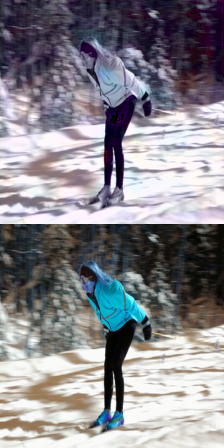

In [ ]:
model.eval()
with torch.no_grad():
  for batch, (X, y,l_channel) in enumerate(test_dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        print(loss)
        image_original = torch.stack((l_channel[0],y[0][0],y[0][1]),dim=0)
        image_original = transforms.functional.to_pil_image(image_original)
        image_original = np.array(image_original)
        image_bw = image_original[:,:,2]
        image_original = cv2.cvtColor(image_original,cv2.COLOR_Luv2RGB)


        image_predicted = torch.stack((l_channel[0],pred[0][0],pred[0][1]),dim=0)
        image_predicted = transforms.functional.to_pil_image(image_predicted)
        image_predicted = np.array(image_predicted)
        image_bw_l = image_predicted[:,:,2]
        image_predicted = cv2.cvtColor(image_predicted,cv2.COLOR_Luv2RGB)
        Hori = np.concatenate((image_predicted, image_original), axis=0)
        cv2_imshow(Hori)

torch.Size([2, 224, 224])

In [ ]:
# Classification Model

In [ ]:
# change resize to 256 with center crop 224 
class Colorization_Dataset(Dataset):
  def __init__(self,file_location,indices):
    self.location = file_location
    # self.image_location = os.listdir(file_location)
    self.image_location = sorted(os.listdir(file_location)[indices[0]:indices[1]])
  def __len__(self):
    return len(self.image_location)
  def __getitem__(self,idx):
    image_bgr = cv2.imread(os.path.join(self.location, self.image_location[idx]))
    image_rgb = cv2.cvtColor(image_bgr,cv2.COLOR_BGR2RGB)
    image_rgb = Image.fromarray(image_rgb)
    image_rgb = transforms.functional.resize(image_rgb,(224,224))
    image_rgb = np.array(image_rgb)
    image_luv = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2Luv)
    bins = np.linspace(0,255,64).astype(int)
    image_ubin = np.digitize(image_luv[:,:,1],bins).astype(np.unit8)
    image_vbin = np.digitize(image_luv[:,:,2],bins).astype(np.unit8)
    image_luv = transforms.functional.to_tensor(image_luv)
    image_ubin = transforms.functional.to_tensor(image_ubin)
    image_vbin = transforms.functional.to_tensor(image_vbin)
    image_l = torch.stack((image_luv[0],image_luv[0],image_luv[0]),dim=0)
    image_l = transforms.functional.normalize(
        image_l,
        mean=[0.4697]*3, 
        std=[0.2610]*3
    )
    return image_l,image_ubin,image_vbin,image_luv[0]

# OpenCv reads color in BGR format whereas Image.fromarray expects the color to be in RGB format hence we convert BGR to RGB

In [ ]:
class ImageColorization(nn.Module):
  def __init__(self):
    super(ImageColorization,self).__init__()
    self.first = model[0:6]
    self.second = model[6:13]
    self.third = model[13:23]
    self.fourth = model[23:]
    self.conv256 = nn.Sequential(
        nn.Conv2d(512,256,(1,1)),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )
    self.conv128 = nn.Sequential(
        nn.Conv2d(256,128,(3,3),(1,1),(1,1)),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )
    self.conv64 = nn.Sequential(
        nn.Conv2d(128,64,(3,3),(1,1),(1,1)),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.conv256_3 = nn.Sequential(
        nn.Conv2d(512,256,(3,3),(1,1),"same"),
        nn.ReLU()
    )
    self.conv64_31 = nn.Sequential(
        nn.Conv2d(256,64,(3,3),(1,1),"same"),
        nn.ReLU()
    )
    self.conv64_32 = nn.Sequential(
        nn.Conv2d(64,64,(3,3),(1,1),"same"),
        nn.ReLU()
    )
    self.conv50_1 = nn.Sequential(
        nn.Conv2d(64,50,(3,3),(1,1),"same"),
        nn.Softmax()
    )
    self.conv50_2 = nn.Sequential(
        nn.Conv2d(64,50,(3,3),(1,1),"same"),
        nn.Softmax()
    )

  def forward(self,x):
    out1 = self.first(x)
    out2 = self.second(out1)
    out3 = self.third(out2)
    out4 = self.fourth(out3)
    out5 = self.conv256(out4)
    out6 = self.conv128(out5+out3)
    out7 = self.conv64(out6+out2)
    out8 = self.conv2(out7+out1)
    return out8

In [ ]:
image_bgr = cv2.imread("/content/drive/MyDrive/Images/667626_18933d713e.jpg")
image_rgb = cv2.cvtColor(image_bgr,cv2.COLOR_BGR2RGB)

In [ ]:
image_luv = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2Luv)
bins = np.linspace(0,255,64).astype(np.uint8)
image_ubin = np.digitize(image_luv[:,:,1],bins).astype(np.uint8)
type(image_luv)

numpy.ndarray

In [ ]:
type(image_ubin)
image_ubin.dtype

dtype('uint8')

In [ ]:
transforms.functional.to_tensor(image_ubin)

tensor([[[0.0941, 0.0941, 0.0941,  ..., 0.0824, 0.0824, 0.0824],
         [0.0941, 0.0941, 0.0941,  ..., 0.0824, 0.0824, 0.0824],
         [0.0941, 0.0941, 0.0941,  ..., 0.0824, 0.0824, 0.0824],
         ...,
         [0.0941, 0.0980, 0.1020,  ..., 0.0902, 0.0902, 0.0902],
         [0.0980, 0.0980, 0.1020,  ..., 0.0941, 0.0941, 0.0941],
         [0.1059, 0.1020, 0.0980,  ..., 0.0941, 0.0941, 0.0941]]])